# Skin Disease Multi-Model Training Notebook

This notebook trains and compares multiple transfer-learning models for skin disease classification from RGB images.

Input:
- Image file (`.jpg`, `.jpeg`, `.png`) from local path or Cloudinary URL.

Output for inference:
- `disease`: predicted class name
- `confidence`: float in [0.0, 1.0]
- `severity`: rule-based level (`Mild`, `Moderate`, `Severe`)

Artifacts saved for every model:
- `<ModelName>.h5`
- `<ModelName>.pkl`
- `<ModelName>_confusion_matrix.png`

Note:
- TensorFlow does not provide a model named `EfficientNet50`.
- This notebook includes `EfficientNetB0` and `EfficientNetB3` as efficient alternatives.


In [4]:
# Optional: uncomment if packages are missing in your environment.
!pip install tensorflow numpy pandas scikit-learn matplotlib seaborn pillow requests h5py jupyterlab ipykernel



  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
  Using cached numpy-2.4.2-cp313-cp313-win_amd64.whl.metadata (6.6 kB)
  Using cached pandas-3.0.0-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached scikit_learn-1.8.0-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl.metadata (52 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pillow-12.1.1-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached h5py-3.15.1-cp313-cp313-win_amd64.whl.metadata (3.1 kB)
  Using cached absl_py-2.4.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.12.19-py2.py3-none-any.whl.metadata (1.0 kB)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using ca

In [3]:
import json
import math
import pickle
import random
import time
from datetime import datetime, timezone
from io import BytesIO
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

np.set_printoptions(suppress=True, precision=4)
pd.set_option("display.max_columns", 200)

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
gpus = tf.config.list_physical_devices("GPU")
print("GPU devices found:", gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Enabled memory growth on GPUs.")
    except Exception as gpu_err:
        print("Could not set GPU memory growth:", gpu_err)
else:
    print("No GPU detected. Training will run on CPU (slower).")


TensorFlow version: 2.20.0
Keras version: 3.13.2
GPU devices found: []
No GPU detected. Training will run on CPU (slower).


In [4]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Paths
PROJECT_ROOT = Path.cwd()
TRAIN_DIR = PROJECT_ROOT / "SkinDisease" / "train"
TEST_DIR = PROJECT_ROOT / "SkinDisease" / "test"
OUTPUT_DIR = PROJECT_ROOT / "trained_artifacts"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Training hyperparameters
BATCH_SIZE = 16
VAL_SPLIT = 0.2
HEAD_EPOCHS = 5
FINE_TUNE_EPOCHS = 3
INITIAL_LR = 1e-3
FINE_TUNE_LR = 1e-5
DROPOUT_RATE = 0.35

# If not None, unfreeze only last N layers in fine-tuning stage
FINE_TUNE_LAST_N = 40

# Models to train (each has its own cell below)
MODEL_SEQUENCE = ["ResNet50", "EfficientNetB0", "EfficientNetB3", "MobileNetV2", "DenseNet121"]
MODEL_IMAGE_SIZE = {
    "ResNet50": 224,
    "EfficientNetB0": 224,
    "EfficientNetB3": 300,
    "MobileNetV2": 224,
    "DenseNet121": 224,
}

print("Project root:", PROJECT_ROOT)
print("Train dir:", TRAIN_DIR, "| exists:", TRAIN_DIR.exists())
print("Test dir:", TEST_DIR, "| exists:", TEST_DIR.exists())
print("Output dir:", OUTPUT_DIR)
print("Models planned:", MODEL_SEQUENCE)


Project root: c:\Users\itzzp\OneDrive\Desktop\ml model train
Train dir: c:\Users\itzzp\OneDrive\Desktop\ml model train\SkinDisease\train | exists: True
Test dir: c:\Users\itzzp\OneDrive\Desktop\ml model train\SkinDisease\test | exists: True
Output dir: c:\Users\itzzp\OneDrive\Desktop\ml model train\trained_artifacts
Models planned: ['ResNet50', 'EfficientNetB0', 'EfficientNetB3', 'MobileNetV2', 'DenseNet121']


Number of train classes: 22
Number of test classes: 22
--------------------------------------------------------------------------------
Train class counts:
Acne                           -> 593
Actinic_Keratosis              -> 748
Benign_tumors                  -> 1093
Bullous                        -> 504
Candidiasis                    -> 248
DrugEruption                   -> 547
Eczema                         -> 1010
Infestations_Bites             -> 524
Lichen                         -> 553
Lupus                          -> 311
Moles                          -> 361
Psoriasis                      -> 820
Rosacea                        -> 254
Seborrh_Keratoses              -> 455
SkinCancer                     -> 693
Sun_Sunlight_Damage            -> 312
Tinea                          -> 923
Unknown_Normal                 -> 1651
Vascular_Tumors                -> 543
Vasculitis                     -> 461
Vitiligo                       -> 714
Warts                          -> 580
-----

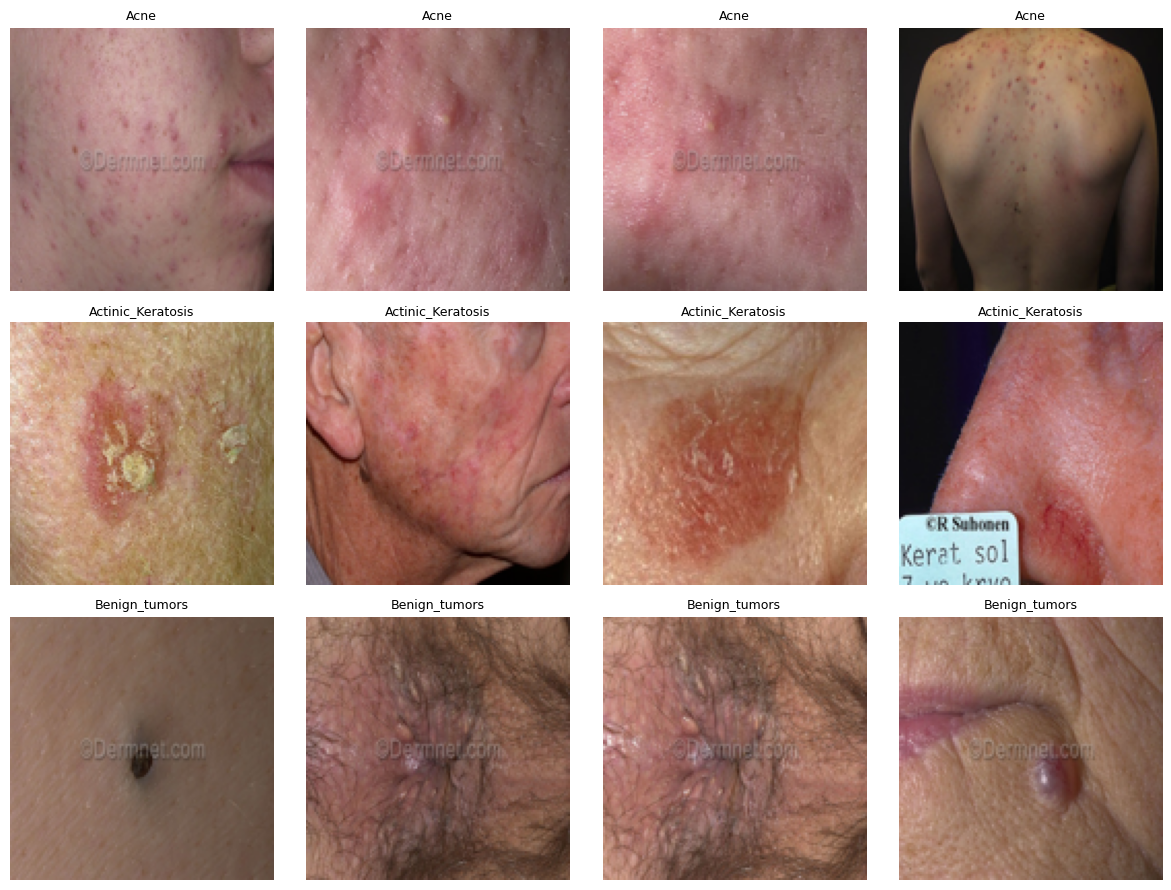

In [5]:
def get_class_names(data_dir: Path):
    return sorted([p.name for p in data_dir.iterdir() if p.is_dir()])


def count_images_per_class(data_dir: Path):
    counts = {}
    for cls_name in get_class_names(data_dir):
        cls_dir = data_dir / cls_name
        counts[cls_name] = len([f for f in cls_dir.glob("*") if f.is_file()])
    return counts


def print_data_overview():
    if not TRAIN_DIR.exists() or not TEST_DIR.exists():
        raise FileNotFoundError("Expected SkinDisease/train and SkinDisease/test directories.")

    train_counts = count_images_per_class(TRAIN_DIR)
    test_counts = count_images_per_class(TEST_DIR)

    print("Number of train classes:", len(train_counts))
    print("Number of test classes:", len(test_counts))
    print("-" * 80)
    print("Train class counts:")
    for k, v in train_counts.items():
        print(f"{k:30s} -> {v}")
    print("-" * 80)
    print("Test class counts:")
    for k, v in test_counts.items():
        print(f"{k:30s} -> {v}")

    train_set = set(train_counts.keys())
    test_set = set(test_counts.keys())
    if train_set != test_set:
        print("WARNING: Train and test class names do not match exactly.")
        print("Only in train:", sorted(train_set - test_set))
        print("Only in test :", sorted(test_set - train_set))
    else:
        print("Train/Test class names match.")


def show_sample_images(data_dir: Path, max_classes: int = 3, samples_per_class: int = 4, image_size=(128, 128)):
    classes = get_class_names(data_dir)[:max_classes]
    if not classes:
        print("No classes found.")
        return

    plt.figure(figsize=(samples_per_class * 3, max_classes * 3))
    plot_idx = 1
    for cls_name in classes:
        files = [f for f in (data_dir / cls_name).glob("*") if f.is_file()][:samples_per_class]
        for file_path in files:
            img = Image.open(file_path).convert("RGB").resize(image_size)
            plt.subplot(max_classes, samples_per_class, plot_idx)
            plt.imshow(img)
            plt.title(cls_name, fontsize=9)
            plt.axis("off")
            plot_idx += 1

    plt.tight_layout()
    plt.show()


print_data_overview()
show_sample_images(TRAIN_DIR, max_classes=3, samples_per_class=4)


In [6]:
def get_model_config(model_name: str):
    model_name = model_name.strip()
    if model_name == "ResNet50":
        return {
            "builder": keras.applications.ResNet50,
            "preprocess": keras.applications.resnet50.preprocess_input,
            "image_size": MODEL_IMAGE_SIZE[model_name],
        }
    if model_name == "EfficientNetB0":
        return {
            "builder": keras.applications.EfficientNetB0,
            "preprocess": keras.applications.efficientnet.preprocess_input,
            "image_size": MODEL_IMAGE_SIZE[model_name],
        }
    if model_name == "EfficientNetB3":
        return {
            "builder": keras.applications.EfficientNetB3,
            "preprocess": keras.applications.efficientnet.preprocess_input,
            "image_size": MODEL_IMAGE_SIZE[model_name],
        }
    if model_name == "MobileNetV2":
        return {
            "builder": keras.applications.MobileNetV2,
            "preprocess": keras.applications.mobilenet_v2.preprocess_input,
            "image_size": MODEL_IMAGE_SIZE[model_name],
        }
    if model_name == "DenseNet121":
        return {
            "builder": keras.applications.DenseNet121,
            "preprocess": keras.applications.densenet.preprocess_input,
            "image_size": MODEL_IMAGE_SIZE[model_name],
        }
    raise ValueError(f"Unsupported model_name: {model_name}")


def build_transfer_model(model_name: str, num_classes: int):
    cfg = get_model_config(model_name)
    image_size = cfg["image_size"]
    input_shape = (image_size, image_size, 3)

    print(f"[{model_name}] Building model with input shape {input_shape} ...")
    inputs = keras.Input(shape=input_shape, name="image")

    # Data augmentation for better generalization
    x = layers.RandomFlip("horizontal", seed=SEED, name="aug_flip")(inputs)
    x = layers.RandomRotation(0.07, seed=SEED, name="aug_rotate")(x)
    x = layers.RandomZoom(0.10, seed=SEED, name="aug_zoom")(x)

    # Model-specific preprocessing
    x = layers.Lambda(lambda t: tf.cast(t, tf.float32), name="cast_float32")(x)
    x = layers.Lambda(cfg["preprocess"], name="model_preprocess")(x)

    try:
        base_model = cfg["builder"](
            include_top=False,
            weights="imagenet",
            input_shape=input_shape,
            pooling="avg",
        )
        print(f"[{model_name}] Loaded ImageNet pretrained weights.")
    except Exception as load_err:
        print(f"[{model_name}] Could not load ImageNet weights. Falling back to random init.")
        print("Reason:", load_err)
        base_model = cfg["builder"](
            include_top=False,
            weights=None,
            input_shape=input_shape,
            pooling="avg",
        )

    base_model.trainable = False
    x = base_model(x, training=False)
    x = layers.Dropout(DROPOUT_RATE, name="dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=f"{model_name}_classifier")

    return model, base_model, cfg


def compile_for_training(model: keras.Model, learning_rate: float):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    print("Compiled model with learning rate:", learning_rate)
    return model


In [7]:
def make_datasets(image_size: int, batch_size: int = BATCH_SIZE):
    print(f"Creating datasets with image size: {image_size}x{image_size}, batch size: {batch_size}")

    train_ds = keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        labels="inferred",
        label_mode="int",
        validation_split=VAL_SPLIT,
        subset="training",
        seed=SEED,
        image_size=(image_size, image_size),
        batch_size=batch_size,
        shuffle=True,
    )
    val_ds = keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        labels="inferred",
        label_mode="int",
        validation_split=VAL_SPLIT,
        subset="validation",
        seed=SEED,
        image_size=(image_size, image_size),
        batch_size=batch_size,
        shuffle=True,
    )
    test_ds = keras.utils.image_dataset_from_directory(
        TEST_DIR,
        labels="inferred",
        label_mode="int",
        image_size=(image_size, image_size),
        batch_size=batch_size,
        shuffle=False,
    )

    # IMPORTANT: capture class names before .prefetch(),
    # because PrefetchDataset does not keep .class_names.
    class_names = list(train_ds.class_names)

    autotune = tf.data.AUTOTUNE
    train_ds = train_ds.prefetch(autotune)
    val_ds = val_ds.prefetch(autotune)
    test_ds = test_ds.prefetch(autotune)
    print("Detected class names:", class_names)
    print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
    print("Val batches  :", tf.data.experimental.cardinality(val_ds).numpy())
    print("Test batches :", tf.data.experimental.cardinality(test_ds).numpy())

    return train_ds, val_ds, test_ds, class_names


def compute_class_weights_from_train_dir(class_names):
    print("Computing class weights from train directory...")
    y = []
    for class_idx, class_name in enumerate(class_names):
        files = [f for f in (TRAIN_DIR / class_name).glob("*") if f.is_file()]
        y.extend([class_idx] * len(files))

    classes = np.arange(len(class_names))
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=np.array(y))
    class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}

    print("Class weight dict:")
    for cls_idx, weight in class_weight_dict.items():
        print(f"  class {cls_idx:2d} ({class_names[cls_idx]}): {weight:.4f}")

    return class_weight_dict


In [8]:
def make_callbacks(model_name: str, stage: str):
    csv_log_path = OUTPUT_DIR / f"{model_name}_{stage}_training_log.csv"
    callback_list = [
        callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=3,
            restore_best_weights=True,
            verbose=1,
        ),
        callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.3,
            patience=2,
            min_lr=1e-7,
            verbose=1,
        ),
        callbacks.CSVLogger(str(csv_log_path)),
    ]
    return callback_list


def plot_training_curves(history_head, history_ft, model_name: str):
    history = {}
    for key in history_head.history:
        history[key] = list(history_head.history.get(key, [])) + list(history_ft.history.get(key, []))

    epochs = range(1, len(history["loss"]) + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["accuracy"], label="train_acc")
    plt.plot(epochs, history["val_accuracy"], label="val_acc")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plot_path = OUTPUT_DIR / f"{model_name}_training_curves.png"
    plt.savefig(plot_path, dpi=140)
    plt.show()
    print(f"[{model_name}] Saved training curve plot -> {plot_path}")


def evaluate_model(model, test_ds, class_names, model_name):
    print(f"[{model_name}] Evaluating on test dataset...")
    y_true = np.concatenate([batch_y.numpy() for _, batch_y in test_ds], axis=0)

    y_prob = model.predict(test_ds, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    report_text = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    print(f"[{model_name}] Test accuracy: {accuracy:.4f}")
    print(f"[{model_name}] Test macro F1: {macro_f1:.4f}")
    print(f"[{model_name}] Classification report:{report_text}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap="Blues", fmt="d", cbar=True)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    cm_path = OUTPUT_DIR / f"{model_name}_confusion_matrix.png"
    plt.savefig(cm_path, dpi=140)
    plt.show()
    print(f"[{model_name}] Saved confusion matrix -> {cm_path}")

    return {
        "accuracy": float(accuracy),
        "macro_f1": float(macro_f1),
        "classification_report": report_dict,
        "confusion_matrix": cm,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_prob,
    }


def export_model_artifacts(model, model_name, class_names, image_size, metrics):
    h5_path = OUTPUT_DIR / f"{model_name}.h5"
    pkl_path = OUTPUT_DIR / f"{model_name}.pkl"

    print(f"[{model_name}] Saving H5 model -> {h5_path}")
    model.save(h5_path)

    bundle = {
        "model_name": model_name,
        "class_names": class_names,
        "image_size": image_size,
        "h5_path": str(h5_path),
        "metrics": {
            "accuracy": metrics["accuracy"],
            "macro_f1": metrics["macro_f1"],
        },
        "saved_at_utc": datetime.now(timezone.utc).isoformat(),
        "pickle_mode": "metadata_only",
        "notes": "If model bytes are unavailable, load model from h5_path.",
    }

    try:
        bundle["pickled_model_bytes"] = pickle.dumps(model)
        bundle["pickle_mode"] = "embedded_model_bytes"
        print(f"[{model_name}] Embedded model bytes into PKL (may be large).")
    except Exception as pickle_err:
        bundle["pickled_model_bytes"] = None
        bundle["pickle_error"] = str(pickle_err)
        print(f"[{model_name}] Full model pickling failed, saved metadata-only PKL.")
        print("Reason:", pickle_err)

    with open(pkl_path, "wb") as f:
        pickle.dump(bundle, f)

    print(f"[{model_name}] Saved PKL bundle -> {pkl_path}")
    return h5_path, pkl_path


In [9]:
all_results = {}
artifact_index = {}
GLOBAL_CLASS_NAMES = None


def train_evaluate_export(model_name: str):
    global GLOBAL_CLASS_NAMES

    if model_name not in MODEL_SEQUENCE:
        raise ValueError(f"Model {model_name} not in MODEL_SEQUENCE: {MODEL_SEQUENCE}")

    start_time = time.time()
    print("\n" + "=" * 100)
    print(f"STARTING MODEL: {model_name}")
    print("=" * 100)

    image_size = MODEL_IMAGE_SIZE[model_name]
    train_ds, val_ds, test_ds, class_names = make_datasets(image_size=image_size, batch_size=BATCH_SIZE)

    if GLOBAL_CLASS_NAMES is None:
        GLOBAL_CLASS_NAMES = class_names
    elif GLOBAL_CLASS_NAMES != class_names:
        raise RuntimeError("Class name order changed across runs. Stop and check dataset ordering.")

    class_weights = compute_class_weights_from_train_dir(class_names)
    model, base_model, cfg = build_transfer_model(model_name, num_classes=len(class_names))
    model.summary()

    # Stage 1: train classification head
    print(f"[{model_name}] Stage 1 training (frozen backbone) ...")
    compile_for_training(model, INITIAL_LR)
    cb_head = make_callbacks(model_name, stage="head")
    history_head = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=HEAD_EPOCHS,
        class_weight=class_weights,
        callbacks=cb_head,
        verbose=1,
    )

    # Stage 2: fine-tune upper layers
    print(f"[{model_name}] Stage 2 fine-tuning ...")
    base_model.trainable = True
    if FINE_TUNE_LAST_N is None:
        freeze_until = int(len(base_model.layers) * 0.8)
    else:
        freeze_until = max(0, len(base_model.layers) - int(FINE_TUNE_LAST_N))

    for layer in base_model.layers[:freeze_until]:
        layer.trainable = False
    for layer in base_model.layers[freeze_until:]:
        layer.trainable = True

    print(f"[{model_name}] Total backbone layers: {len(base_model.layers)}")
    print(f"[{model_name}] Frozen layers: {freeze_until}")
    print(f"[{model_name}] Trainable layers: {len(base_model.layers) - freeze_until}")

    compile_for_training(model, FINE_TUNE_LR)
    cb_ft = make_callbacks(model_name, stage="finetune")
    history_ft = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=FINE_TUNE_EPOCHS,
        class_weight=class_weights,
        callbacks=cb_ft,
        verbose=1,
    )

    plot_training_curves(history_head, history_ft, model_name)
    metrics = evaluate_model(model, test_ds, class_names, model_name)
    h5_path, pkl_path = export_model_artifacts(model, model_name, class_names, image_size, metrics)

    duration_sec = time.time() - start_time
    all_results[model_name] = {
        "model_name": model_name,
        "image_size": image_size,
        "accuracy": metrics["accuracy"],
        "macro_f1": metrics["macro_f1"],
        "duration_sec": float(duration_sec),
        "confusion_matrix": metrics["confusion_matrix"],
        "report": metrics["classification_report"],
    }
    artifact_index[model_name] = {
        "h5_path": str(h5_path),
        "pkl_path": str(pkl_path),
        "class_names": class_names,
        "image_size": image_size,
        "accuracy": metrics["accuracy"],
        "macro_f1": metrics["macro_f1"],
    }

    with open(OUTPUT_DIR / "artifact_index.json", "w", encoding="utf-8") as f:
        json.dump(artifact_index, f, indent=2)

    print(f"[{model_name}] Finished in {duration_sec/60:.2f} minutes")
    print(f"[{model_name}] Accuracy={metrics['accuracy']:.4f}, Macro-F1={metrics['macro_f1']:.4f}")
    print(f"[{model_name}] Artifacts saved. Current trained models: {list(all_results.keys())}")
    keras.backend.clear_session()

    return all_results[model_name]


## Per-Model Training Cells

Run these cells one by one. Each cell will:
1. train the model,
2. generate confusion matrix,
3. save `.h5` and `.pkl` files,
4. add results to `all_results` and `artifact_index`.



STARTING MODEL: ResNet50
Creating datasets with image size: 224x224, batch size: 16
Found 13898 files belonging to 22 classes.
Using 11119 files for training.
Found 13898 files belonging to 22 classes.
Using 2779 files for validation.
Found 1546 files belonging to 22 classes.
Detected class names: ['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']
Train batches: 695
Val batches  : 174
Test batches : 97
Computing class weights from train directory...
Class weight dict:
  class  0 (Acne): 1.0653
  class  1 (Actinic_Keratosis): 0.8446
  class  2 (Benign_tumors): 0.5780
  class  3 (Bullous): 1.2534
  class  4 (Candidiasis): 2.5473
  class  5 (DrugEruption): 1.1549
  class  6 (Eczema): 0.6255
  class  7 (Infestations_Bites): 1.2056
 

Model: "ResNet50_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_flip (RandomFlip)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_rotate (RandomRotation)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_zoom (RandomZoom)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_float32 (Lambda)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ model_preprocess (Lambda)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 22)             │        45,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,632,790 (90.15 MB)

 Trainable params: 45,078 (176.09 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

[ResNet50] Stage 1 training (frozen backbone) ...
Compiled model with learning rate: 0.001
Epoch 1/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 572s 805ms/step - accuracy: 0.3207 - loss: 2.5688 - val_accuracy: 0.3962 - val_loss: 2.0668 - learning_rate: 0.0010
Epoch 2/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 545s 784ms/step - accuracy: 0.4311 - loss: 2.0425 - val_accuracy: 0.4534 - val_loss: 1.8644 - learning_rate: 0.0010
Epoch 3/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 558s 803ms/step - accuracy: 0.4646 - loss: 1.8949 - val_accuracy: 0.4516 - val_loss: 1.9342 - learning_rate: 0.0010
Epoch 4/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 534s 768ms/step - accuracy: 0.4765 - loss: 1.8360 - val_accuracy: 0.4822 - val_loss: 1.8025 - learning_rate: 0.0010
Epoch 5/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 535s 769ms/step - accuracy: 0.4946 - loss: 1.7780 - val_accuracy: 0.4718 - val_loss: 1.8947 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.
[ResNet50] Stage 2 fine-tuning ...
[ResNet50] Total backbone layers: 176
[R

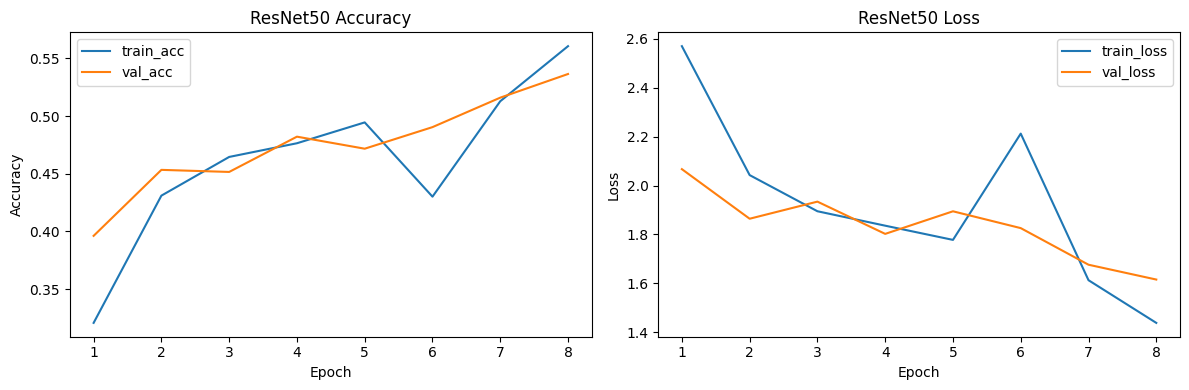

[ResNet50] Saved training curve plot -> c:\Users\itzzp\OneDrive\Desktop\ml model train\trained_artifacts\ResNet50_training_curves.png
[ResNet50] Evaluating on test dataset...
97/97 ━━━━━━━━━━━━━━━━━━━━ 65s 634ms/step
[ResNet50] Test accuracy: 0.5317
[ResNet50] Test macro F1: 0.4960
[ResNet50] Classification report:                     precision    recall  f1-score   support

               Acne     0.7377    0.6923    0.7143        65
  Actinic_Keratosis     0.6000    0.2892    0.3902        83
      Benign_tumors     0.4077    0.4380    0.4223       121
            Bullous     0.5833    0.5091    0.5437        55
        Candidiasis     0.5161    0.5926    0.5517        27
       DrugEruption     0.6279    0.4426    0.5192        61
             Eczema     0.3631    0.5446    0.4357       112
 Infestations_Bites     0.4091    0.3000    0.3462        60
             Lichen     0.5455    0.2951    0.3830        61
              Lupus     0.2821    0.3235    0.3014        34
            

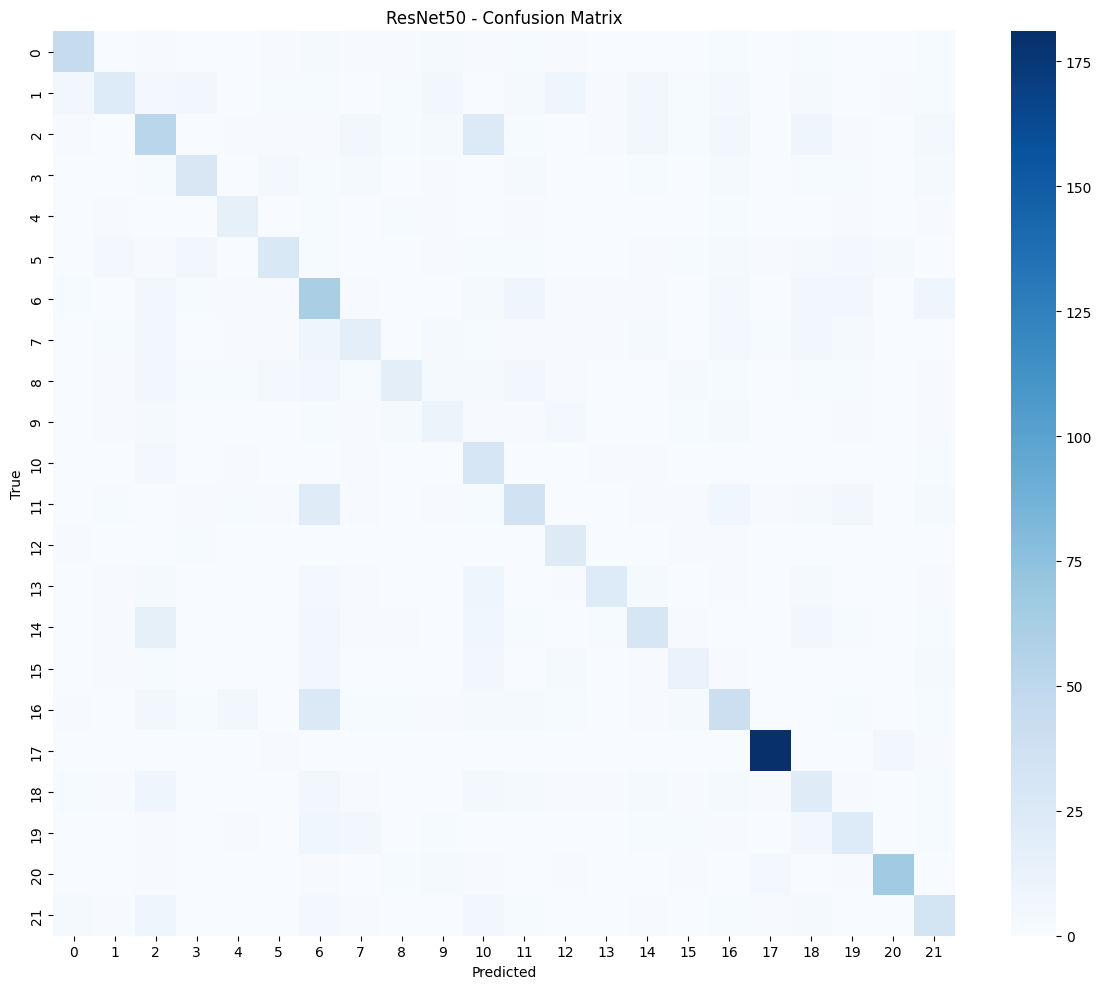

[ResNet50] Saved confusion matrix -> c:\Users\itzzp\OneDrive\Desktop\ml model train\trained_artifacts\ResNet50_confusion_matrix.png
[ResNet50] Saving H5 model -> c:\Users\itzzp\OneDrive\Desktop\ml model train\trained_artifacts\ResNet50.h5
[ResNet50] Embedded model bytes into PKL (may be large).
[ResNet50] Saved PKL bundle -> c:\Users\itzzp\OneDrive\Desktop\ml model train\trained_artifacts\ResNet50.pkl
[ResNet50] Finished in 96.70 minutes
[ResNet50] Accuracy=0.5317, Macro-F1=0.4960
[ResNet50] Artifacts saved. Current trained models: ['ResNet50']


{'model_name': 'ResNet50',
 'image_size': 224,
 'accuracy': 0.5316946959896507,
 'macro_f1': 0.495972925386164,
 'duration_sec': 5802.061207294464,
 'confusion_matrix': array([[ 45,   0,   1,   0,   0,   1,   3,   1,   1,   3,   1,   2,   1,
           0,   0,   0,   2,   0,   2,   0,   0,   2],
        [  6,  24,   4,   6,   0,   2,   2,   0,   2,   6,   0,   3,   9,
           1,   6,   2,   4,   0,   3,   0,   1,   2],
        [  1,   0,  53,   0,   1,   1,   1,   5,   2,   3,  25,   2,   0,
           1,   5,   2,   5,   0,   9,   1,   0,   4],
        [  0,   0,   2,  28,   0,   4,   2,   3,   0,   1,   0,   3,   0,
           0,   2,   0,   3,   0,   2,   2,   0,   3],
        [  0,   1,   0,   0,  16,   0,   2,   0,   2,   1,   0,   1,   0,
           0,   0,   0,   2,   0,   0,   1,   0,   1],
        [  0,   4,   1,   5,   0,  27,   2,   0,   0,   1,   2,   2,   0,
           0,   1,   2,   3,   1,   3,   4,   3,   0],
        [  2,   0,   6,   2,   1,   1,  61,   1,   0,   0,

In [8]:
# Train ResNet50
resnet50_result = train_evaluate_export("ResNet50")
resnet50_result



STARTING MODEL: EfficientNetB0
Creating datasets with image size: 224x224, batch size: 16
Found 13898 files belonging to 22 classes.
Using 11119 files for training.
Found 13898 files belonging to 22 classes.
Using 2779 files for validation.
Found 1546 files belonging to 22 classes.
Detected class names: ['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']
Train batches: 695
Val batches  : 174
Test batches : 97
Computing class weights from train directory...
Class weight dict:
  class  0 (Acne): 1.0653
  class  1 (Actinic_Keratosis): 0.8446
  class  2 (Benign_tumors): 0.5780
  class  3 (Bullous): 1.2534
  class  4 (Candidiasis): 2.5473
  class  5 (DrugEruption): 1.1549
  class  6 (Eczema): 0.6255
  class  7 (Infestations_Bites): 1.

Model: "EfficientNetB0_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_flip (RandomFlip)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_rotate (RandomRotation)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_zoom (RandomZoom)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_float32 (Lambda)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ model_preprocess (Lambda)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 22)             │        28,182 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,077,753 (15.56 MB)

 Trainable params: 28,182 (110.09 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

[EfficientNetB0] Stage 1 training (frozen backbone) ...
Compiled model with learning rate: 0.001
Epoch 1/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 366s 495ms/step - accuracy: 0.0398 - loss: 3.0947 - val_accuracy: 0.0302 - val_loss: 3.0915 - learning_rate: 0.0010
Epoch 2/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 582s 837ms/step - accuracy: 0.0485 - loss: 3.0947 - val_accuracy: 0.0727 - val_loss: 3.0916 - learning_rate: 0.0010
Epoch 3/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.0691 - loss: 3.1063
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
695/695 ━━━━━━━━━━━━━━━━━━━━ 264s 377ms/step - accuracy: 0.0520 - loss: 3.0947 - val_accuracy: 0.0727 - val_loss: 3.0916 - learning_rate: 0.0010
Epoch 4/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 236s 339ms/step - accuracy: 0.0583 - loss: 3.0943 - val_accuracy: 0.0727 - val_loss: 3.0918 - learning_rate: 3.0000e-04
Epoch 5/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.0737 - loss: 3.1032
Epoch 5: ReduceLROnPlateau reducing lea

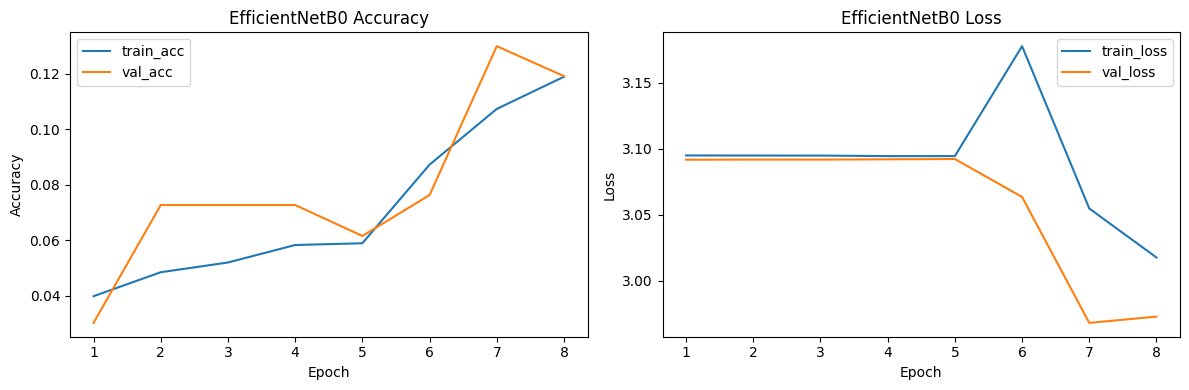

[EfficientNetB0] Saved training curve plot -> c:\Users\itzzp\OneDrive\Desktop\ml model train\trained_artifacts\EfficientNetB0_training_curves.png
[EfficientNetB0] Evaluating on test dataset...
97/97 ━━━━━━━━━━━━━━━━━━━━ 35s 309ms/step


c:\Users\itzzp\OneDrive\Desktop\ML model train\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\itzzp\OneDrive\Desktop\ML model train\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\itzzp\OneDrive\Desktop\ML model train\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

[EfficientNetB0] Test accuracy: 0.1248
[EfficientNetB0] Test macro F1: 0.0620
[EfficientNetB0] Classification report:                     precision    recall  f1-score   support

               Acne     0.1197    0.2615    0.1643        65
  Actinic_Keratosis     0.0000    0.0000    0.0000        83
      Benign_tumors     0.1212    0.0331    0.0519       121
            Bullous     0.0000    0.0000    0.0000        55
        Candidiasis     0.0000    0.0000    0.0000        27
       DrugEruption     0.0000    0.0000    0.0000        61
             Eczema     0.1392    0.5357    0.2210       112
 Infestations_Bites     0.0000    0.0000    0.0000        60
             Lichen     0.0000    0.0000    0.0000        61
              Lupus     0.0000    0.0000    0.0000        34
              Moles     0.0789    0.5500    0.1379        40
          Psoriasis     0.0000    0.0000    0.0000        88
            Rosacea     0.0000    0.0000    0.0000        28
  Seborrh_Keratoses     0.08

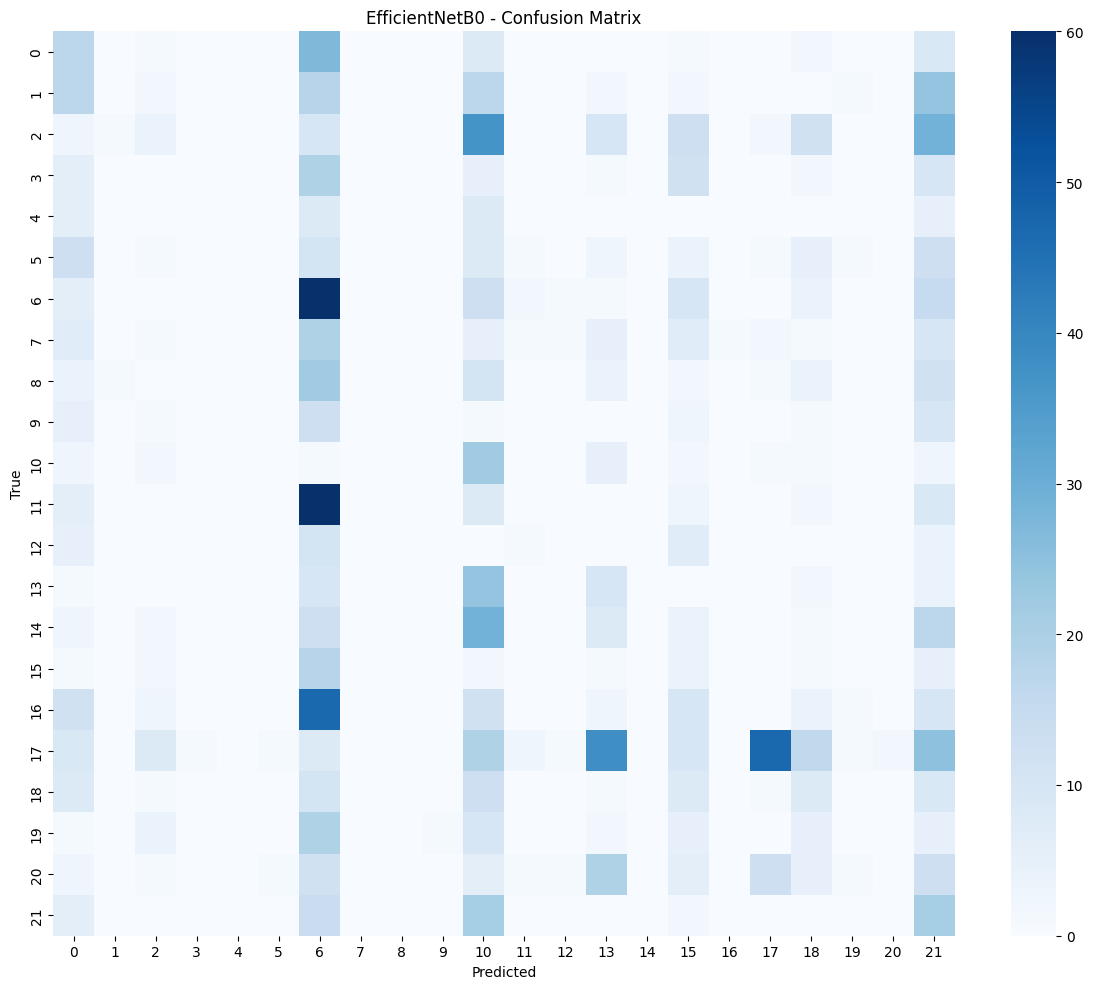

[EfficientNetB0] Saved confusion matrix -> c:\Users\itzzp\OneDrive\Desktop\ml model train\trained_artifacts\EfficientNetB0_confusion_matrix.png
[EfficientNetB0] Saving H5 model -> c:\Users\itzzp\OneDrive\Desktop\ml model train\trained_artifacts\EfficientNetB0.h5
[EfficientNetB0] Embedded model bytes into PKL (may be large).
[EfficientNetB0] Saved PKL bundle -> c:\Users\itzzp\OneDrive\Desktop\ml model train\trained_artifacts\EfficientNetB0.pkl
[EfficientNetB0] Finished in 44.59 minutes
[EfficientNetB0] Accuracy=0.1248, Macro-F1=0.0620
[EfficientNetB0] Artifacts saved. Current trained models: ['EfficientNetB0']


{'model_name': 'EfficientNetB0',
 'image_size': 224,
 'accuracy': 0.12483829236739974,
 'macro_f1': 0.06195488334063384,
 'duration_sec': 2675.6096398830414,
 'confusion_matrix': array([[17,  0,  1,  0,  0,  0, 27,  0,  0,  0,  8,  0,  0,  0,  0,  1,
          0,  0,  2,  0,  0,  9],
        [17,  0,  2,  0,  0,  0, 18,  0,  0,  0, 17,  0,  0,  2,  0,  2,
          0,  0,  0,  1,  0, 24],
        [ 3,  1,  4,  0,  0,  0, 10,  0,  0,  0, 37,  0,  0, 10,  0, 13,
          0,  2, 12,  0,  0, 29],
        [ 6,  0,  0,  0,  0,  0, 19,  0,  0,  0,  5,  0,  0,  1,  0, 12,
          0,  0,  2,  0,  0, 10],
        [ 6,  0,  0,  0,  0,  0,  8,  0,  0,  0,  8,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  5],
        [13,  0,  1,  0,  0,  0, 11,  0,  0,  0,  8,  1,  0,  3,  0,  4,
          0,  1,  5,  1,  0, 13],
        [ 6,  0,  0,  0,  0,  0, 60,  0,  0,  0, 13,  2,  1,  1,  0, 10,
          0,  0,  4,  0,  0, 15],
        [ 7,  0,  1,  0,  0,  0, 19,  0,  0,  0,  5,  1,  1,  5,  0,  7,


In [10]:
# Train EfficientNetB0
efficientnetb0_result = train_evaluate_export("EfficientNetB0")
efficientnetb0_result


In [11]:
# Train EfficientNetB3 (efficient alternative to your requested EfficientNet50 naming)
efficientnetb3_result = train_evaluate_export("EfficientNetB3")
efficientnetb3_result



STARTING MODEL: EfficientNetB3
Creating datasets with image size: 300x300, batch size: 16
Found 13898 files belonging to 22 classes.
Using 11119 files for training.
Found 13898 files belonging to 22 classes.
Using 2779 files for validation.
Found 1546 files belonging to 22 classes.
Detected class names: ['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']
Train batches: 695
Val batches  : 174
Test batches : 97
Computing class weights from train directory...
Class weight dict:
  class  0 (Acne): 1.0653
  class  1 (Actinic_Keratosis): 0.8446
  class  2 (Benign_tumors): 0.5780
  class  3 (Bullous): 1.2534
  class  4 (Candidiasis): 2.5473
  class  5 (DrugEruption): 1.1549
  class  6 (Eczema): 0.6255
  class  7 (Infestations_Bites): 1.

Model: "EfficientNetB3_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_flip (RandomFlip)           │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_rotate (RandomRotation)     │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_zoom (RandomZoom)           │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_float32 (Lambda)           │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ model_preprocess (Lambda)       │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 22)             │        33,814 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,817,349 (41.26 MB)

 Trainable params: 33,814 (132.09 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

[EfficientNetB3] Stage 1 training (frozen backbone) ...
Compiled model with learning rate: 0.001
Epoch 1/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 680s 940ms/step - accuracy: 0.0402 - loss: 3.0947 - val_accuracy: 0.0702 - val_loss: 3.0913 - learning_rate: 0.0010
Epoch 2/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 1579s 2s/step - accuracy: 0.0492 - loss: 3.0946 - val_accuracy: 0.0727 - val_loss: 3.0912 - learning_rate: 0.0010
Epoch 3/5
695/695 ━━━━━━━━━━━━━━━━━━━━ 1373s 2s/step - accuracy: 0.0528 - loss: 3.0945 - val_accuracy: 0.0730 - val_loss: 3.0910 - learning_rate: 0.0010
Epoch 4/5
 67/695 ━━━━━━━━━━━━━━━━━━━━ 16:55 2s/step - accuracy: 0.0838 - loss: 3.1558

KeyboardInterrupt: 

In [ ]:
# Train MobileNetV2
mobilenetv2_result = train_evaluate_export("MobileNetV2")
mobilenetv2_result


In [ ]:
# Train DenseNet121
densenet121_result = train_evaluate_export("DenseNet121")
densenet121_result


In [20]:
def compare_trained_models():
    if not all_results:
        print("No models found in all_results. Run training cells first.")
        return None

    rows = []
    for name, res in all_results.items():
        rows.append(
            {
                "model": name,
                "accuracy": res["accuracy"],
                "macro_f1": res["macro_f1"],
                "duration_min": res["duration_sec"] / 60.0,
                "image_size": res["image_size"],
            }
        )

    df = pd.DataFrame(rows).sort_values(by=["accuracy", "macro_f1"], ascending=False).reset_index(drop=True)
    print("Model comparison table:")
    print(df.to_string(index=False))

    csv_path = OUTPUT_DIR / "model_comparison.csv"
    df.to_csv(csv_path, index=False)
    print("Saved model comparison CSV ->", csv_path)

    plt.figure(figsize=(10, 4))
    sns.barplot(data=df, x="model", y="accuracy")
    plt.title("Accuracy Comparison")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.barplot(data=df, x="model", y="macro_f1")
    plt.title("Macro F1 Comparison")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

    names = list(df["model"])
    cols = 2
    rows_count = math.ceil(len(names) / cols)
    fig, axes = plt.subplots(rows_count, cols, figsize=(12, 5 * rows_count))
    axes = np.array(axes).reshape(-1)

    for idx, model_name in enumerate(names):
        cm = all_results[model_name]["confusion_matrix"]
        sns.heatmap(cm, cmap="Blues", cbar=False, ax=axes[idx])
        axes[idx].set_title(f"{model_name} CM")
        axes[idx].set_xlabel("Pred")
        axes[idx].set_ylabel("True")

    for idx in range(len(names), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    grid_path = OUTPUT_DIR / "all_models_confusion_matrices.png"
    plt.savefig(grid_path, dpi=140)
    plt.show()
    print("Saved confusion matrix grid ->", grid_path)

    best_name = df.iloc[0]["model"]
    print("Best model by accuracy:", best_name)
    print("Best model artifact paths:", artifact_index[best_name])

    return df


comparison_df = compare_trained_models()
comparison_df


No models found in all_results. Run training cells first.


In [19]:
print("Artifacts in output folder:")
for path in sorted(OUTPUT_DIR.glob("*")):
    print(path.name)

print("artifact_index.json preview:")
index_path = OUTPUT_DIR / "artifact_index.json"
if index_path.exists():
    print(index_path.read_text(encoding="utf-8")[:3000])
else:
    print("artifact_index.json not found yet.")


Artifacts in output folder:
artifact_index.json preview:
artifact_index.json not found yet.


In [18]:
SEVERITY_KEYWORDS = {
    "severe": ["cancer", "melanoma", "lupus", "vasculitis"],
    "moderate": ["eczema", "psoriasis", "rosacea", "keratosis", "bullous", "candidiasis", "lichen"],
}


def infer_severity(disease_name: str, confidence: float):
    # Rule-based severity. Replace with supervised severity model if true severity labels exist.
    name = disease_name.lower()
    if any(k in name for k in SEVERITY_KEYWORDS["severe"]):
        base = "Severe"
    elif any(k in name for k in SEVERITY_KEYWORDS["moderate"]):
        base = "Moderate"
    else:
        base = "Mild"

    # Confidence guardrail: low confidence should not be marked severe.
    if confidence < 0.50:
        return "Mild"
    if confidence < 0.70 and base == "Severe":
        return "Moderate"
    return base


def load_image_from_source(image_source, image_size):
    source = str(image_source)
    if source.startswith("http://") or source.startswith("https://"):
        print("Loading image from URL (Cloudinary or other):", source)
        response = requests.get(source, timeout=30)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        print("Loading image from local path:", source)
        image = Image.open(source).convert("RGB")

    image = image.resize((image_size, image_size))
    arr = np.array(image, dtype=np.float32)
    return arr


def load_model_from_artifact(model_name: str):
    if model_name not in artifact_index:
        raise ValueError(f"{model_name} not found in artifact_index. Train model first.")

    info = artifact_index[model_name]
    pkl_path = Path(info["pkl_path"])
    h5_path = Path(info["h5_path"])

    with open(pkl_path, "rb") as f:
        bundle = pickle.load(f)

    model = None
    if isinstance(bundle, dict) and bundle.get("pickle_mode") == "embedded_model_bytes" and bundle.get("pickled_model_bytes") is not None:
        try:
            model = pickle.loads(bundle["pickled_model_bytes"])
            print(f"[{model_name}] Loaded model from PKL embedded bytes.")
        except Exception as e:
            print(f"[{model_name}] PKL bytes load failed, fallback to H5.")
            print("Reason:", e)

    if model is None:
        model = keras.models.load_model(h5_path)
        print(f"[{model_name}] Loaded model from H5:", h5_path)

    return model, info


def predict_skin_disease(image_source, model_name=None):
    if model_name is None:
        if not all_results:
            raise ValueError("No trained models available. Train at least one model first.")
        model_name = max(all_results, key=lambda n: all_results[n]["accuracy"])
        print("No model_name provided. Using best current model:", model_name)

    model, info = load_model_from_artifact(model_name)
    image_size = int(info["image_size"])
    class_names = info["class_names"]

    image = load_image_from_source(image_source, image_size=image_size)
    batch = np.expand_dims(image, axis=0)

    probs = model.predict(batch, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    disease = class_names[pred_idx]
    confidence = float(probs[pred_idx])
    severity = infer_severity(disease, confidence)

    result = {
        "model_used": model_name,
        "disease": disease,
        "confidence": confidence,
        "severity": severity,
    }
    print("Prediction result:", result)
    return result


# Example usage:
# result = predict_skin_disease(r"C:\path\to\image.jpg", model_name="ResNet50")
# result = predict_skin_disease("https://res.cloudinary.com/.../image.jpg", model_name="EfficientNetB0")


## Notes and Debugging Tips

- Run cells top-to-bottom once, then run model cells one by one.
- Each model saves `.h5`, `.pkl`, training logs, and confusion matrix images in `trained_artifacts`.
- If GPU memory errors occur, lower `BATCH_SIZE` to `8` and reduce epochs.
- For production-quality severity output, train a dedicated severity-label model instead of rule-based logic.
